<a href="https://colab.research.google.com/github/mjgpinheiro/Econophysics/blob/main/produtividade_no_trabalho.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Dados de Produtividade no Trabalho:
  country  NY.GDP.PCAP.PP.KD
0     USA       60212.123625
1     CAN       47932.256687
2     GBR       45179.580113
3     FRA       44190.283344
4     DEU       52534.370088

Dados Normalizados:
         NY.GDP.PCAP.PP.KD
country                   
ARE               1.000000
BRA               0.131875
CAN               0.652148
CHN               0.132803
DEU               0.723876

Dados Normalizados com Nomes dos Países:
         NY.GDP.PCAP.PP.KD          country_name
country                                         
ARE               1.000000  United Arab Emirates
BRA               0.131875                Brazil
CAN               0.652148                Canada
CHN               0.132803                 China
DEU               0.723876               Germany


<ipython-input-1-2cab17668192>:69: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=normalized_df['country_name'], y=normalized_df['NY.GDP.PCAP.PP.KD'], palette=colors)


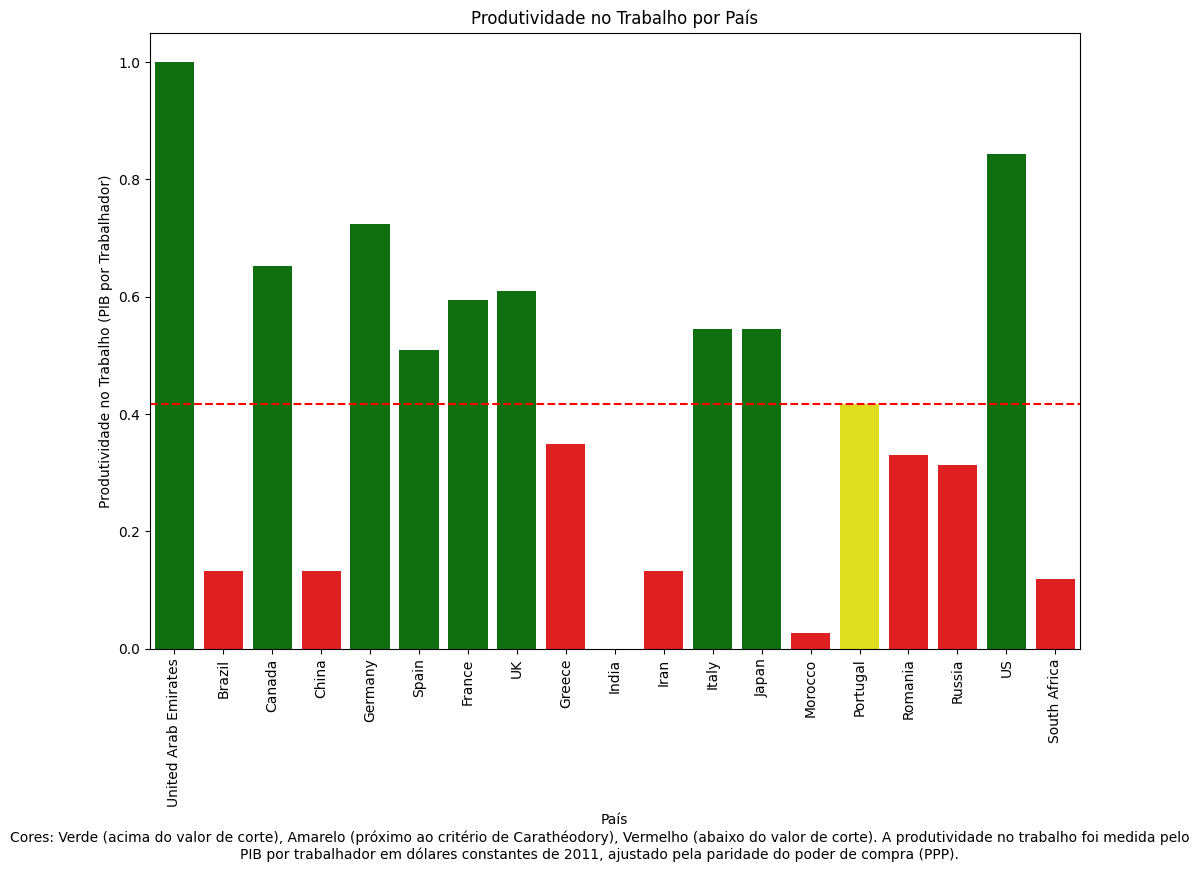

Valor de corte para a produtividade no trabalho: 0.41684190449393477


In [1]:
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler

# Função para buscar dados da API do Banco Mundial
def fetch_world_bank_data(indicator, country_codes):
    all_data = []
    for country in country_codes:
        url = f"http://api.worldbank.org/v2/country/{country}/indicator/{indicator}?format=json&per_page=1000&date=2015:2020"
        response = requests.get(url)
        if response.status_code == 200:
            data = response.json()
            if data and len(data) > 1:
                df = pd.DataFrame(data[1])
                df = df[['countryiso3code', 'date', 'value']].dropna().rename(columns={'countryiso3code': 'country', 'value': indicator})
                df[indicator] = df.groupby('country')[indicator].transform('mean')  # Calcula a média ao longo dos anos
                all_data.append(df[['country', indicator]].drop_duplicates())
    return pd.concat(all_data, ignore_index=True)

# Lista de países (códigos ISO3) para incluir na análise
country_codes = ['USA', 'CAN', 'GBR', 'FRA', 'DEU', 'CHN', 'JPN', 'IND', 'BRA', 'ZAF', 'PRT', 'MAR', 'ESP', 'ROU', 'ITA', 'GRC', 'ARE', 'IRN', 'RUS']

# Buscar dados de produtividade no trabalho
productivity_data = fetch_world_bank_data('NY.GDP.PCAP.PP.KD', country_codes)  # PIB por trabalhador (US$ constantes de 2011)

# Imprimir as primeiras linhas do conjunto de dados para garantir que os dados foram buscados corretamente
print("Dados de Produtividade no Trabalho:")
print(productivity_data.head())

# Garantir que os dados contenham apenas códigos de países únicos, calculando a média se houver múltiplas entradas
productivity_data = productivity_data.groupby('country').mean().reset_index()

# Normalizar os dados
scaler = MinMaxScaler()
normalized_data = scaler.fit_transform(productivity_data.iloc[:, 1:])  # Excluindo a coluna do país
normalized_df = pd.DataFrame(normalized_data, columns=productivity_data.columns[1:], index=productivity_data['country'])

# Imprimir dados normalizados
print("\nDados Normalizados:")
print(normalized_df.head())

# Função para mapear códigos de países para nomes de países
def fetch_country_names():
    url = "https://raw.githubusercontent.com/datasets/country-codes/master/data/country-codes.csv"
    country_data = pd.read_csv(url)
    country_data = country_data[['ISO3166-1-Alpha-3', 'CLDR display name']]
    country_data.columns = ['country', 'country_name']
    return country_data

# Buscar nomes dos países e mesclar com os dados normalizados
country_names = fetch_country_names()
normalized_df = normalized_df.reset_index().merge(country_names, on='country').set_index('country')

# Imprimir dados finais com nomes dos países
print("\nDados Normalizados com Nomes dos Países:")
print(normalized_df.head())

# Definir o valor de corte (por exemplo, o índice de produtividade mediano)
cutoff_value = normalized_df['NY.GDP.PCAP.PP.KD'].median()

# Determinar cores com base na produtividade
colors = ['green' if x > cutoff_value else 'red' if x < cutoff_value * 0.95 else 'yellow' for x in normalized_df['NY.GDP.PCAP.PP.KD']]

# Visualizar os dados
plt.figure(figsize=(12, 8))
sns.barplot(x=normalized_df['country_name'], y=normalized_df['NY.GDP.PCAP.PP.KD'], palette=colors)
plt.axhline(y=cutoff_value, color='r', linestyle='--')
plt.xticks(rotation=90)
plt.title('Produtividade no Trabalho por País')
plt.xlabel('País')
plt.ylabel('Produtividade no Trabalho (PIB por Trabalhador)')
plt.figtext(0.5, -0.15, ("Cores: Verde (acima do valor de corte), Amarelo (próximo ao critério de Carathéodory), "
                         "Vermelho (abaixo do valor de corte). A produtividade no trabalho foi medida pelo PIB por trabalhador "
                         "em dólares constantes de 2011, ajustado pela paridade do poder de compra (PPP)."), wrap=True, horizontalalignment='center', fontsize=10)
plt.show()

# Imprimir o valor de corte para referência
print(f"Valor de corte para a produtividade no trabalho: {cutoff_value}")
